In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import torch

# Pastikan CUDA tersedia
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Pilih GPU pertama (NVIDIA)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = pd.read_csv('/content/drive/MyDrive/heart.csv')

In [14]:
X = data.drop(columns=['target']).values
y = data['target'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
batch_sizes = [32, 64, 128]
train_datasets = [DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True) for batch_size in batch_sizes]
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, neurons_per_layer, activation):
        super(MLP, self).__init__()
        layers = []

        # Input Layer
        layers.append(nn.Linear(input_size, neurons_per_layer))
        layers.append(activation)

        # Hidden Layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(activation)

        # Output Layer (2 kelas: 0 dan 1)
        layers.append(nn.Linear(neurons_per_layer, 2))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [16]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, current_lr, hidden_layers, neurons, activation_name):
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss_history.append(train_loss / len(train_loader))
        test_loss_history.append(test_loss / len(test_loader))
        accuracy_history.append(correct / total)

        # Tambahkan print setiap epoch untuk menunjukkan parameter yang sedang berjalan
        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Hidden Layers = {hidden_layers}, Neurons = {neurons}, Activation = {activation_name}, "
              f"Learning Rate = {current_lr}, "
              f"Train Loss = {train_loss_history[-1]:.4f}, "
              f"Test Loss = {test_loss_history[-1]:.4f}, Accuracy = {accuracy_history[-1]:.4f}")

    return train_loss_history, test_loss_history, accuracy_history


In [17]:
hidden_layers_options = [1, 2, 3]
neurons_options = [4, 8, 16, 32]
activation_functions = {
    'linear': nn.Identity(),
    'sigmoid': nn.Sigmoid(),
    'relu': nn.ReLU(),
    'softmax': nn.Softmax(dim=1),
    'tanh': nn.Tanh()
}
epochs_options = [1, 10, 25, 50, 100]
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]

# Fungsi pelatihan model

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs,
                current_lr, hidden_layers, neurons, activation_name):
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        train_loss_history.append(train_loss / len(train_loader))
        test_loss_history.append(test_loss / len(test_loader))
        accuracy_history.append(correct / total)

        # Log setiap epoch dengan parameter saat ini
        print(f"Epoch {epoch + 1}/{epochs} | LR: {current_lr}\t| HL: {hidden_layers}\t| "
              f"Neu: {neurons} | {activation_name} | "
              f"TrL: {train_loss_history[-1]:.4f}\t| "
              f"TeL: {test_loss_history[-1]:.4f}\t| "
              f"Acu: {accuracy_history[-1]:.4f}")

    return train_loss_history, test_loss_history, accuracy_history


In [18]:
import pandas as pd

# Fungsi untuk menjalankan eksperimen dengan jumlah hidden layers tertentu
def run_experiment(hidden_layers):
    results = []
    print(f"Memulai eksperimen untuk hidden layers = {hidden_layers}")

    for neurons in neurons_options:
        for activation_name, activation in activation_functions.items():
            for epochs in epochs_options:
                for lr in learning_rates:
                    for train_loader in train_datasets:
                        model = MLP(X_train.shape[1], hidden_layers, neurons, activation)
                        criterion = nn.CrossEntropyLoss()
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                        # Latih model
                        train_loss, test_loss, accuracy = train_model(
                            model,
                            train_loader,
                            test_loader,
                            criterion,
                            optimizer,
                            epochs,
                            current_lr=lr,
                            hidden_layers=hidden_layers,
                            neurons=neurons,
                            activation_name=activation_name
                        )

                        # Simpan hasil
                        results.append({
                            'hidden_layers': hidden_layers,
                            'neurons': neurons,
                            'activation': activation_name,
                            'epochs': epochs,
                            'learning_rate': lr,
                            'batch_size': train_loader.batch_size,
                            'accuracy': accuracy[-1]
                        })

    return results


In [19]:
def save_results_to_csv(results, filename):
    # Konversi hasil ke DataFrame
    results_df = pd.DataFrame(results)

    # Simpan hasil dengan mode append
    with open(filename, 'a') as f:
        # Jika file sudah ada, tambahkan tanpa header
        if f.tell() == 0:  # Cek apakah file kosong
            results_df.to_csv(f, index=False)
        else:
            results_df.to_csv(f, index=False, header=False)

# Eksperimen dan simpan secara bertahap
filename = '/content/drive/MyDrive/Hasil.csv'  # Nama file CSV
all_results = []

Hidden layer 1

In [20]:
results = run_experiment(1)  # Ganti dengan fungsi eksperimen Anda
all_results.extend(results)
save_results_to_csv(results, filename)  # Simpan hasil HL1 ke CSV


Streaming output truncated to the last 5000 lines.
Epoch 41/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4900	| TeL: 0.7031	| Acu: 0.7805
Epoch 42/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4886	| TeL: 0.5248	| Acu: 0.7707
Epoch 43/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4354	| TeL: 0.4965	| Acu: 0.7805
Epoch 44/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4202	| TeL: 0.5024	| Acu: 0.7854
Epoch 45/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4129	| TeL: 0.6440	| Acu: 0.7756
Epoch 46/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4220	| TeL: 0.4590	| Acu: 0.7805
Epoch 47/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.3946	| TeL: 0.4991	| Acu: 0.7951
Epoch 48/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4178	| TeL: 0.5987	| Acu: 0.8098
Epoch 49/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4366	| TeL: 0.5455	| Acu: 0.8244
Epoch 50/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | TrL: 0.4482	| TeL: 0.4663	| Acu: 0.8000
Epoch 1/50 | LR: 1	| HL: 1	| Neu: 32 | softmax | 

Hidden layer 2

In [21]:
results = run_experiment(2)  # Ganti dengan fungsi eksperimen Anda
all_results.extend(results)
save_results_to_csv(results, filename)

Streaming output truncated to the last 5000 lines.
Epoch 41/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.4878	| TeL: 0.5515	| Acu: 0.7415
Epoch 42/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5031	| TeL: 0.5458	| Acu: 0.7707
Epoch 43/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5655	| TeL: 0.5980	| Acu: 0.6683
Epoch 44/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5364	| TeL: 0.5752	| Acu: 0.6976
Epoch 45/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.6171	| TeL: 0.6476	| Acu: 0.5415
Epoch 46/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5374	| TeL: 0.4869	| Acu: 0.7707
Epoch 47/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.4990	| TeL: 0.5586	| Acu: 0.5415
Epoch 48/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5391	| TeL: 0.6296	| Acu: 0.5707
Epoch 49/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5863	| TeL: 0.6079	| Acu: 0.6976
Epoch 50/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | TrL: 0.5700	| TeL: 0.5665	| Acu: 0.7707
Epoch 1/50 | LR: 1	| HL: 2	| Neu: 32 | softmax | 

Hidden layer 3

In [22]:
results = run_experiment(3)  # Ganti dengan fungsi eksperimen Anda
all_results.extend(results)
save_results_to_csv(results, filename)

Streaming output truncated to the last 5000 lines.
Epoch 41/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7450	| TeL: 0.6946	| Acu: 0.4976
Epoch 42/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7934	| TeL: 0.9428	| Acu: 0.5024
Epoch 43/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7327	| TeL: 0.8359	| Acu: 0.5024
Epoch 44/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7533	| TeL: 0.7115	| Acu: 0.5024
Epoch 45/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7409	| TeL: 0.7653	| Acu: 0.4976
Epoch 46/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7654	| TeL: 0.6932	| Acu: 0.4976
Epoch 47/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7157	| TeL: 0.7194	| Acu: 0.5024
Epoch 48/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7065	| TeL: 0.6998	| Acu: 0.5024
Epoch 49/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7540	| TeL: 0.6937	| Acu: 0.4976
Epoch 50/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | TrL: 0.7320	| TeL: 0.6936	| Acu: 0.4976
Epoch 1/50 | LR: 1	| HL: 3	| Neu: 32 | softmax | 

In [23]:
print(f"Semua eksperimen selesai. Hasil disimpan secara bertahap di '{filename}'.")

Semua eksperimen selesai. Hasil disimpan secara bertahap di '/content/drive/MyDrive/Hasil.csv'.


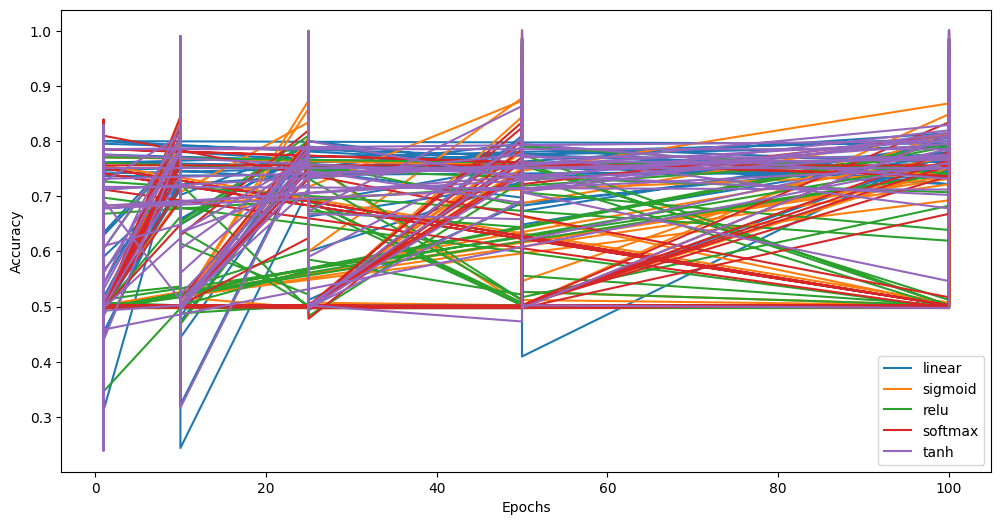

In [26]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
results_df = pd.read_csv('/content/drive/MyDrive/Hasil.csv')
# Plotting results (example for one parameter comparison)
plt.figure(figsize=(12, 6))
for activation in results_df['activation'].unique():
    subset = results_df[results_df['activation'] == activation]
    plt.plot(subset['epochs'], subset['accuracy'], label=f"{activation}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the experimental results from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Hasil.csv')

# Display the first few rows of the DataFrame to understand its structure
results_df.head()

# Plot configurations for visualization
def plot_experiment_results(results_df, metric, title):
    plt.figure(figsize=(10, 6))
    results_df_sorted = results_df.sort_values(by=metric, ascending=False)
    plt.bar(results_df_sorted.index, results_df_sorted[metric], color='blue')
    plt.xlabel('Experiment Index')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.show()


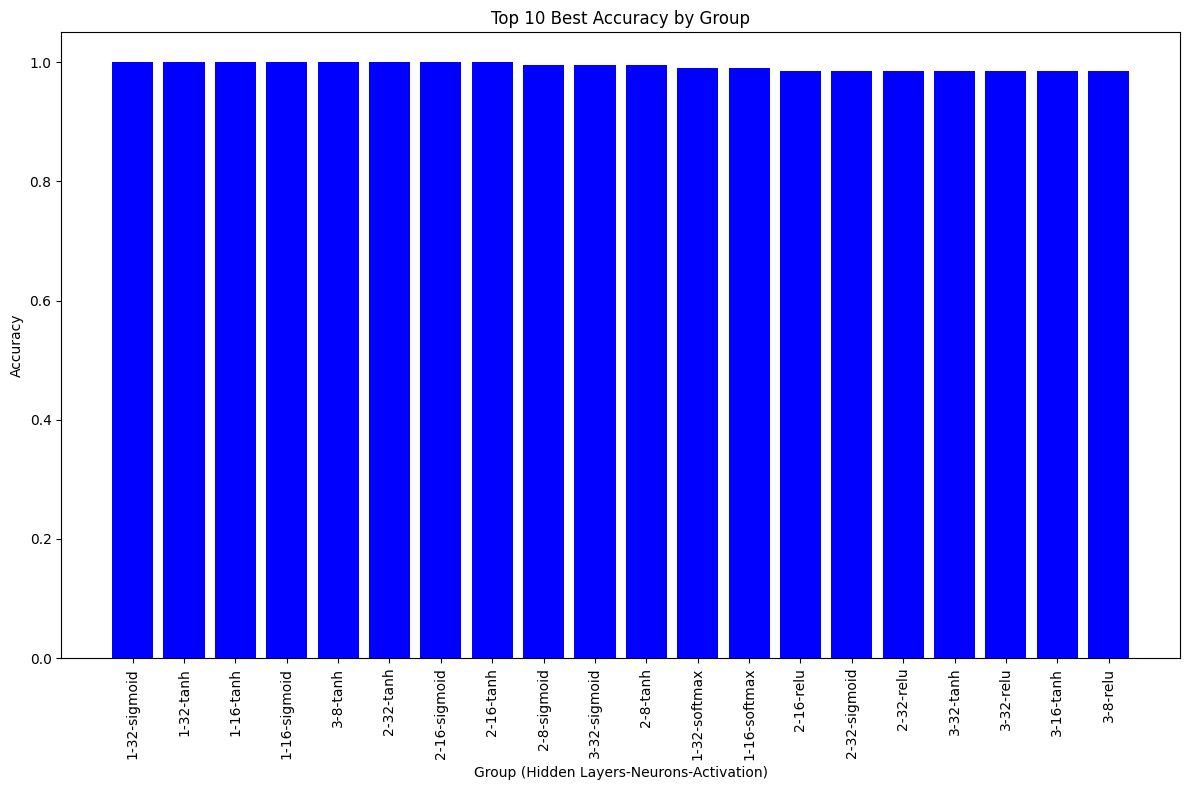

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_best_accuracy_by_group(results_df, grouping_columns, metric='accuracy', title='Best Accuracy by Group', top_n=20):

    # Group by the specified columns and find the best accuracy within each group
    grouped = results_df.groupby(grouping_columns).agg({metric: 'max'}).reset_index()

    # Sort by the metric for better visualization
    grouped_sorted = grouped.sort_values(by=metric, ascending=False)

    # Select top N groups
    grouped_sorted = grouped_sorted.head(top_n)

    # Create labels for grouped experiments
    grouped_sorted['group'] = grouped_sorted[grouping_columns].astype(str).agg('-'.join, axis=1)

    # Plot the results
    plt.figure(figsize=(12, 8))
    plt.bar(grouped_sorted['group'], grouped_sorted[metric], color='blue')
    plt.xticks(rotation=90)
    plt.xlabel('Group (Hidden Layers-Neurons-Activation)')
    plt.ylabel(metric.capitalize())
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Contoh penggunaan
# results_df adalah DataFrame yang memuat kolom seperti 'hidden_layers', 'neurons', 'activation', dan 'accuracy'.
grouping_columns = ['hidden_layers', 'neurons', 'activation']
plot_best_accuracy_by_group(results_df, grouping_columns, metric='accuracy', title='Top 10 Best Accuracy by Group', top_n=20)